In [ ]:
# 🧠 MeIA 2025 - Pipeline de Análisis de Sentimientos en Pueblos Mágicos
# Instalación de dependencias
!pip install transformers torch accelerate datasets scikit-learn pandas numpy matplotlib seaborn wordcloud nltk spacy textblob

# Descargar recursos necesarios
import nltk
nltk.download('stopwords')
nltk.download('punkt')
!python -m spacy download es_core_news_sm

# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Para ML tradicional
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

# Para transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import pipeline, EarlyStoppingCallback
import torch
from datasets import Dataset

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Dependencias instaladas correctamente!")
print("🔥 GPU disponible:", torch.cuda.is_available())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 79.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
🚀 Dependencias instaladas correctamente!
🔥 GPU disponible: True


In [ ]:
# ====================================================================
# 📊 CARGA Y EXPLORACIÓN DE DATOS
# ====================================================================

# Cargar datos de entrenamiento
print("📁 Cargando datos de entrenamiento...")
train_data = pd.read_excel('/content/MeIA_2025_train.xlsx')

# Cargar datos de prueba
print("📁 Cargando datos de prueba...")
test_data = pd.read_excel('/content/MeIA_2025_test_wo_labels.xlsx')

print(f"✅ Datos cargados: {len(train_data)} entrenamientos, {len(test_data)} pruebas")

# Información básica de los datos
print("\n📋 Información del dataset de entrenamiento:")
print(train_data.info())
print("\n📊 Estadísticas descriptivas:")
print(train_data.describe())

# Mostrar ejemplos
print("\n🔍 Primeras 5 reseñas:")
print(train_data.head())

📁 Cargando datos de entrenamiento...
📁 Cargando datos de prueba...
✅ Datos cargados: 5000 entrenamientos, 2500 pruebas

📋 Información del dataset de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Review    5000 non-null   object 
 1   Polarity  5000 non-null   float64
 2   Town      5000 non-null   object 
 3   Region    5000 non-null   object 
 4   Type      5000 non-null   object 
dtypes: float64(1), object(4)
memory usage: 195.4+ KB
None

📊 Estadísticas descriptivas:
         Polarity
count  5000.00000
mean      3.20000
std       1.40014
min       1.00000
25%       2.00000
50%       3.00000
75%       4.00000
max       5.00000

🔍 Primeras 5 reseñas:
                                              Review  Polarity          Town  \
0  Un Restaurante te invita por su ambiente tan a...       2.0   Tlaquepaque   
1  Pagamos 25 pesos por

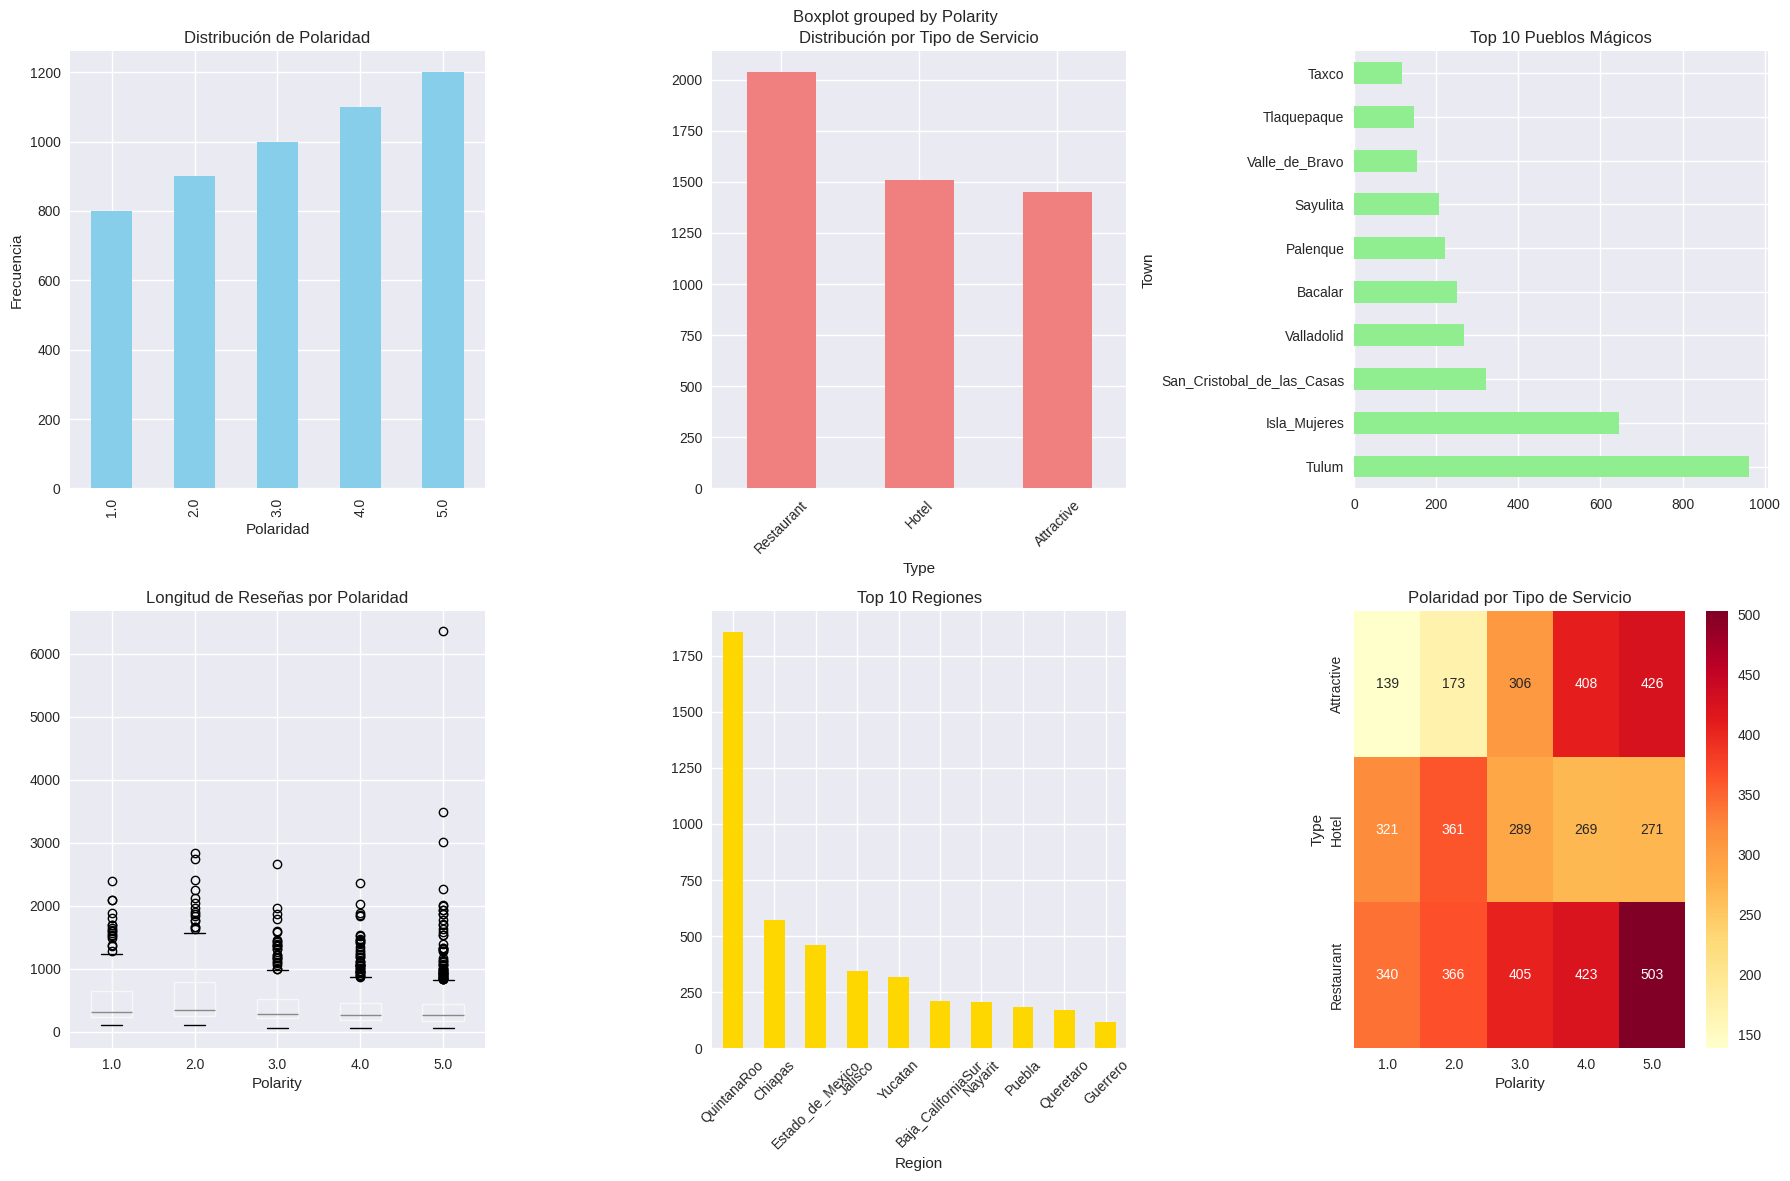


📊 Estadísticas por polaridad:
         Review_Length            Town        Type
                  mean     std nunique    <lambda>
Polarity                                          
1.0             447.31  310.75      39  Restaurant
2.0             482.24  334.70      40  Restaurant
3.0             401.10  276.53      40  Restaurant
4.0             361.74  270.28      40  Restaurant
5.0             365.24  349.91      40  Restaurant


In [ ]:
# ====================================================================
# 🔍 ANÁLISIS EXPLORATORIO DE DATOS
# ====================================================================

# Crear figura con subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🧠 MeIA 2025 - Análisis Exploratorio de Datos', fontsize=16, fontweight='bold')

# 1. Distribución de polaridad
train_data['Polarity'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Distribución de Polaridad')
axes[0,0].set_xlabel('Polaridad')
axes[0,0].set_ylabel('Frecuencia')

# 2. Distribución por tipo de servicio
train_data['Type'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Distribución por Tipo de Servicio')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Top 10 pueblos mágicos
train_data['Town'].value_counts().head(10).plot(kind='barh', ax=axes[0,2], color='lightgreen')
axes[0,2].set_title('Top 10 Pueblos Mágicos')

# 4. Longitud de reseñas por polaridad
train_data['Review_Length'] = train_data['Review'].str.len()
train_data.boxplot(column='Review_Length', by='Polarity', ax=axes[1,0])
axes[1,0].set_title('Longitud de Reseñas por Polaridad')

# 5. Distribución por región
train_data['Region'].value_counts().head(10).plot(kind='bar', ax=axes[1,1], color='gold')
axes[1,1].set_title('Top 10 Regiones')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Heatmap de polaridad por tipo
pivot_table = train_data.groupby(['Type', 'Polarity']).size().unstack(fill_value=0)
sns.heatmap(pivot_table, annot=True, fmt='d', ax=axes[1,2], cmap='YlOrRd')
axes[1,2].set_title('Polaridad por Tipo de Servicio')

plt.tight_layout()
plt.show()

# Estadísticas adicionales
print("\n📊 Estadísticas por polaridad:")
polarity_stats = train_data.groupby('Polarity').agg({
    'Review_Length': ['mean', 'std'],
    'Town': 'nunique',
    'Type': lambda x: x.value_counts().index[0]  # Tipo más común
}).round(2)
print(polarity_stats)

🔧 Aplicando preprocesamiento...
✅ Preprocesamiento completado


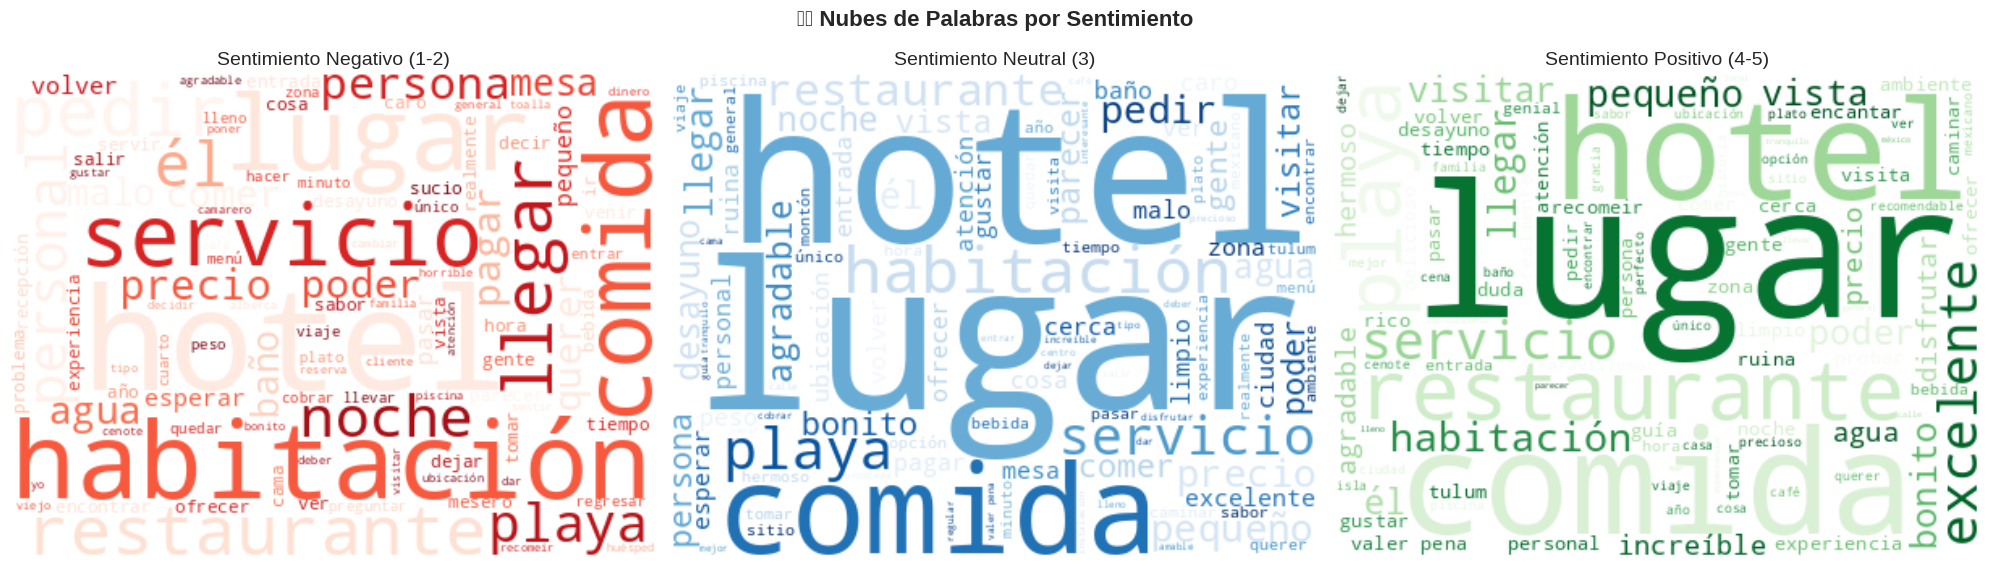

In [ ]:
# ====================================================================
# 🔧 PREPROCESAMIENTO DE TEXTO
# ====================================================================

import spacy
from nltk.corpus import stopwords

# Cargar modelo de spaCy
nlp = spacy.load("es_core_news_sm")
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text, deep_clean=True):
    """
    Preprocesa el texto con diferentes niveles de limpieza
    """
    if pd.isna(text):
        return ""

    # Convertir a minúsculas
    text = text.lower()

    # Remover URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remover menciones y hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    if deep_clean:
        # Remover puntuación pero mantener signos de exclamación e interrogación
        text = re.sub(r'[^\w\s¡!¿?]', ' ', text)

        # Procesar con spaCy
        doc = nlp(text)

        # Lematización y filtrado
        tokens = []
        for token in doc:
            if (not token.is_stop and
                not token.is_punct and
                not token.is_space and
                len(token.text) > 2 and
                token.text not in stop_words):
                tokens.append(token.lemma_)

        text = ' '.join(tokens)

    # Remover espacios extra
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Aplicar preprocesamiento
print("🔧 Aplicando preprocesamiento...")
train_data['Review_Clean'] = train_data['Review'].apply(lambda x: preprocess_text(x, deep_clean=False))
train_data['Review_Deep_Clean'] = train_data['Review'].apply(lambda x: preprocess_text(x, deep_clean=True))

test_data['Review_Clean'] = test_data['Review'].apply(lambda x: preprocess_text(x, deep_clean=False))
test_data['Review_Deep_Clean'] = test_data['Review'].apply(lambda x: preprocess_text(x, deep_clean=True))

print("✅ Preprocesamiento completado")

# ====================================================================
# 📈 VISUALIZACIÓN DE PALABRAS FRECUENTES
# ====================================================================

# Generar nubes de palabras por polaridad
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('☁️ Nubes de Palabras por Sentimiento', fontsize=16, fontweight='bold')

# Polaridad negativa (1-2)
negative_text = ' '.join(train_data[train_data['Polarity'] <= 2]['Review_Deep_Clean'])
wordcloud_neg = WordCloud(width=400, height=300, background_color='white',
                         colormap='Reds', max_words=100).generate(negative_text)
axes[0].imshow(wordcloud_neg, interpolation='bilinear')
axes[0].set_title('Sentimiento Negativo (1-2)', fontsize=14)
axes[0].axis('off')

# Polaridad neutral (3)
neutral_text = ' '.join(train_data[train_data['Polarity'] == 3]['Review_Deep_Clean'])
wordcloud_neu = WordCloud(width=400, height=300, background_color='white',
                         colormap='Blues', max_words=100).generate(neutral_text)
axes[1].imshow(wordcloud_neu, interpolation='bilinear')
axes[1].set_title('Sentimiento Neutral (3)', fontsize=14)
axes[1].axis('off')

# Polaridad positiva (4-5)
positive_text = ' '.join(train_data[train_data['Polarity'] >= 4]['Review_Deep_Clean'])
wordcloud_pos = WordCloud(width=400, height=300, background_color='white',
                         colormap='Greens', max_words=100).generate(positive_text)
axes[2].imshow(wordcloud_pos, interpolation='bilinear')
axes[2].set_title('Sentimiento Positivo (4-5)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ====================================================================
# 🤖 MODELOS DE MACHINE LEARNING TRADICIONAL
# ====================================================================

# Preparar datos para ML tradicional
X_train = train_data['Review_Deep_Clean']
y_train = train_data['Polarity']

# Dividir en entrenamiento y validación
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Definir modelos y pipelines
models = {
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),

    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),

    'SVM': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('classifier', SVC(kernel='rbf', random_state=42))
    ]),

    'Gradient Boosting': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('classifier', GradientBoostingClassifier(random_state=42))
    ]),

    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('classifier', MultinomialNB())
    ])
}

# Entrenar y evaluar modelos
print("🤖 Entrenando modelos de ML tradicional...")
results = {}

for name, model in models.items():
    print(f"\n📊 Entrenando {name}...")

    # Entrenar modelo
    model.fit(X_train_ml, y_train_ml)

    # Predicciones
    y_pred = model.predict(X_val_ml)

    # Métricas
    accuracy = accuracy_score(y_val_ml, y_pred)
    f1 = f1_score(y_val_ml, y_pred, average='weighted')

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': y_pred
    }

    print(f"✅ {name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

# Mostrar resultados
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()]
})

print("\n📊 Resumen de resultados ML tradicional:")
print(results_df.sort_values('F1-Score', ascending=False))

🤖 Entrenando modelos de ML tradicional...

📊 Entrenando Logistic Regression...
✅ Logistic Regression - Accuracy: 0.4420, F1-Score: 0.4354

📊 Entrenando Random Forest...
✅ Random Forest - Accuracy: 0.4140, F1-Score: 0.3991

📊 Entrenando SVM...
✅ SVM - Accuracy: 0.4370, F1-Score: 0.4327

📊 Entrenando Gradient Boosting...
✅ Gradient Boosting - Accuracy: 0.3910, F1-Score: 0.3837

📊 Entrenando Naive Bayes...
✅ Naive Bayes - Accuracy: 0.4260, F1-Score: 0.4140

📊 Resumen de resultados ML tradicional:
                 Model  Accuracy  F1-Score
0  Logistic Regression     0.442  0.435360
2                  SVM     0.437  0.432651
4          Naive Bayes     0.426  0.413999
1        Random Forest     0.414  0.399146
3    Gradient Boosting     0.391  0.383700


In [ ]:
# ====================================================================
# 🚀 MODELO TRANSFORMER (BETO) - VERSIÓN ANTI-OVERFITTING
# ====================================================================

print("\n🚀 Configurando modelo Transformer (BETO) con protección anti-overfitting...")

# Usar BETO (BERT en español)
model_name = "dccuchile/bert-base-spanish-wwm-uncased"

# Preparar datos para transformers - CORRECCIÓN PRINCIPAL
def prepare_data_for_transformers(texts, labels=None):
    """Prepara datos para transformers"""
    data = {"text": texts.tolist()}
    if labels is not None:
        # CORRECCIÓN: Asegurar que las etiquetas sean enteros
        # Ajustar etiquetas (1-5 -> 0-4) y convertir a int
        adjusted_labels = (labels - 1).astype(int).tolist()  # Añadido .astype(int)
        data["labels"] = adjusted_labels
    return Dataset.from_dict(data)

# Verificar tipos de datos antes de crear datasets
print("🔍 Verificando tipos de datos...")
print(f"Tipo de y_train_ml: {y_train_ml.dtype}")
print(f"Tipo de y_val_ml: {y_val_ml.dtype}")
print(f"Valores únicos en y_train_ml: {sorted(y_train_ml.unique())}")

# Asegurar que las etiquetas sean enteros desde el principio
y_train_ml = y_train_ml.astype(int)
y_val_ml = y_val_ml.astype(int)

print(f"✅ Después de conversión - Tipo de y_train_ml: {y_train_ml.dtype}")

# Crear datasets
train_dataset = prepare_data_for_transformers(X_train_ml, y_train_ml)
val_dataset = prepare_data_for_transformers(X_val_ml, y_val_ml)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

# Tokenizar datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Verificar formato de las etiquetas en el dataset
print("🔍 Verificando formato de etiquetas en dataset:")
print(f"Primeras 5 etiquetas del train_dataset: {train_dataset['labels'][:5]}")
print(f"Tipo de las etiquetas: {type(train_dataset['labels'][0])}")

# Configurar modelo
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    problem_type="single_label_classification"
)

# 🛡️ CONFIGURACIÓN ANTI-OVERFITTING - CAMBIOS PRINCIPALES:
training_args_anti_overfitting = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,                    # ✅ REDUCIDO: De 5 a 4 epochs máximo
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.1,                      # ✅ AUMENTADO: De 0.01 a 0.1 (más regularización)
    learning_rate=2e-5,                    # ✅ REDUCIDO: Learning rate más conservador
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",       # ✅ CORRECTO: Usar F1 como métrica
    greater_is_better=True,
    fp16=True,
    dataloader_drop_last=False,
    gradient_accumulation_steps=2,
    # 🛡️ NUEVAS CONFIGURACIONES ANTI-OVERFITTING:
    warmup_ratio=0.1,                      # ✅ NUEVO: Más warmup para estabilidad
    lr_scheduler_type="cosine",            # ✅ NUEVO: Scheduler que reduce LR gradualmente
    save_total_limit=2,                    # ✅ NUEVO: Solo guardar 2 checkpoints mejores
)

# Función de métricas
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted')
    }

# 🛡️ TRAINER CON EARLY STOPPING MÁS AGRESIVO
trainer_anti_overfitting = Trainer(
    model=model,
    args=training_args_anti_overfitting,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # ✅ REDUCIDO: De 2 a 1 epoch patience
)

# Entrenar modelo con manejo de errores
print("🔥 Entrenando modelo BETO con protección anti-overfitting...")
print("🛡️ Configuraciones aplicadas:")
print("   - Epochs máximos: 4 (reducido)")
print("   - Weight decay: 0.1 (aumentado)")
print("   - Learning rate: 2e-5 (reducido)")
print("   - Early stopping: 1 epoch patience (más agresivo)")
print("   - Scheduler: cosine (decaimiento gradual)")

try:
    trainer_anti_overfitting.train()

    # Evaluar modelo
    print("📊 Evaluando modelo BETO...")
    eval_results = trainer_anti_overfitting.evaluate()

    print(f"✅ BETO (Anti-Overfitting) - Accuracy: {eval_results['eval_accuracy']:.4f}, F1-Score: {eval_results['eval_f1']:.4f}")

    # 📊 DIAGNÓSTICO POST-ENTRENAMIENTO
    print("\n🔍 Diagnóstico de entrenamiento:")

    # Obtener historial de logs si está disponible
    log_history = trainer_anti_overfitting.state.log_history

    if len(log_history) > 2:
        # Buscar el último epoch con métricas de validación
        eval_logs = [log for log in log_history if 'eval_loss' in log]
        if len(eval_logs) >= 2:
            last_eval = eval_logs[-1]
            prev_eval = eval_logs[-2]

            eval_loss = last_eval.get('eval_loss', None)
            train_loss = last_eval.get('train_loss', None)

            if eval_loss is not None:
                print(f"   Último validation loss: {eval_loss:.4f}")
            else:
                print("   Último validation loss: N/A")

            if train_loss is not None:
                print(f"   Último training loss: {train_loss:.4f}")
            else:
                print("   Último training loss: N/A")

            # Calcular ratio training/validation loss
            if eval_loss is not None and train_loss is not None:
                ratio = eval_loss / train_loss
                print(f"   Ratio Val/Train Loss: {ratio:.2f}")

                if ratio > 2.0:
                    print("   ⚠️  ADVERTENCIA: Posible overfitting (ratio > 2.0)")
                elif ratio < 1.5:
                    print("   ✅ SALUDABLE: Buen balance training/validation")
                else:
                    print("   🟡 ACEPTABLE: Ratio moderado")

    # Añadir BETO a los resultados
    results['BETO (Anti-Overfitting)'] = {
        'model': trainer_anti_overfitting,
        'accuracy': eval_results['eval_accuracy'],
        'f1_score': eval_results['eval_f1']
    }

    # Actualizar tabla de resultados
    results_df_updated = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[model]['accuracy'] for model in results.keys()],
        'F1-Score': [results[model]['f1_score'] for model in results.keys()]
    })

    print("\n📊 Resumen actualizado de resultados:")
    print(results_df_updated.sort_values('F1-Score', ascending=False))

    print("\n🎯 NOTAS IMPORTANTES:")
    print("   - El modelo se detendrá automáticamente si F1 no mejora en 1 epoch")
    print("   - Mayor regularización previene memorización")
    print("   - Learning rate reducido para aprendizaje más estable")
    print("   - Si aún hay overfitting, considera reducir epochs a 3")

except Exception as e:
    print(f"❌ Error durante el entrenamiento: {str(e)}")
    print("🔍 Información adicional para debug:")
    print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
    print(f"Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB" if torch.cuda.is_available() else "N/A")


🚀 Configurando modelo Transformer (BETO) con protección anti-overfitting...
🔍 Verificando tipos de datos...
Tipo de y_train_ml: int64
Tipo de y_val_ml: int64
Valores únicos en y_train_ml: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
✅ Después de conversión - Tipo de y_train_ml: int64


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

🔍 Verificando formato de etiquetas en dataset:
Primeras 5 etiquetas del train_dataset: [1, 3, 2, 3, 2]
Tipo de las etiquetas: <class 'int'>


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔥 Entrenando modelo BETO con protección anti-overfitting...
🛡️ Configuraciones aplicadas:
   - Epochs máximos: 4 (reducido)
   - Weight decay: 0.1 (aumentado)
   - Learning rate: 2e-5 (reducido)
   - Early stopping: 1 epoch patience (más agresivo)
   - Scheduler: cosine (decaimiento gradual)


Epoch,Training Loss,Validation Loss


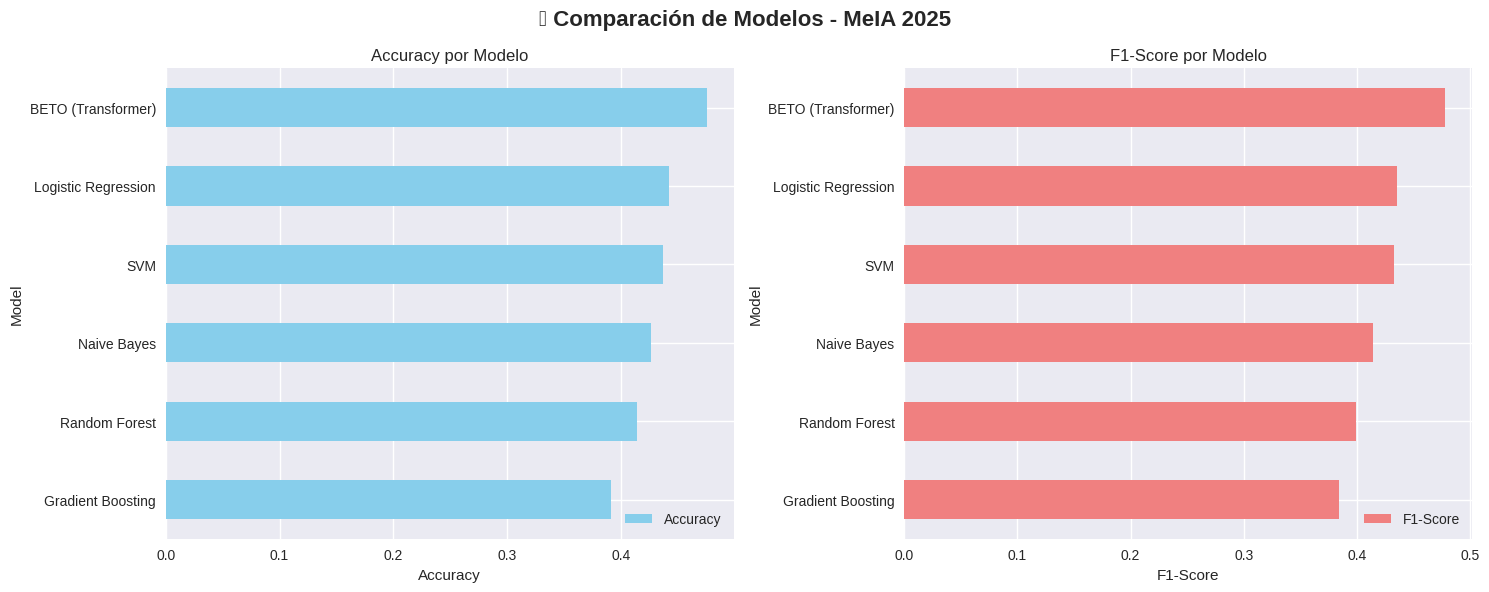


🏆 RANKING FINAL DE MODELOS:
6. BETO (Transformer)
   📊 Accuracy: 0.4750
   🎯 F1-Score: 0.4778

1. Logistic Regression
   📊 Accuracy: 0.4420
   🎯 F1-Score: 0.4354

3. SVM
   📊 Accuracy: 0.4370
   🎯 F1-Score: 0.4327

5. Naive Bayes
   📊 Accuracy: 0.4260
   🎯 F1-Score: 0.4140

2. Random Forest
   📊 Accuracy: 0.4140
   🎯 F1-Score: 0.3991

4. Gradient Boosting
   📊 Accuracy: 0.3910
   🎯 F1-Score: 0.3837



In [ ]:
# ====================================================================
# 📊 COMPARACIÓN FINAL DE MODELOS
# ====================================================================

# Actualizar DataFrame de resultados
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()]
})

# Visualizar comparación
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('🏆 Comparación de Modelos - MeIA 2025', fontsize=16, fontweight='bold')

# Gráfico de accuracy
results_df.sort_values('Accuracy').plot(x='Model', y='Accuracy', kind='barh', ax=ax1, color='skyblue')
ax1.set_title('Accuracy por Modelo')
ax1.set_xlabel('Accuracy')

# Gráfico de F1-Score
results_df.sort_values('F1-Score').plot(x='Model', y='F1-Score', kind='barh', ax=ax2, color='lightcoral')
ax2.set_title('F1-Score por Modelo')
ax2.set_xlabel('F1-Score')

plt.tight_layout()
plt.show()

# Mostrar tabla final ordenada
print("\n🏆 RANKING FINAL DE MODELOS:")
print("="*50)
final_ranking = results_df.sort_values('F1-Score', ascending=False)
for idx, row in final_ranking.iterrows():
    print(f"{idx+1}. {row['Model']}")
    print(f"   📊 Accuracy: {row['Accuracy']:.4f}")
    print(f"   🎯 F1-Score: {row['F1-Score']:.4f}")
    print()

In [ ]:
# ====================================================================
# 🔮 PREDICCIONES EN CONJUNTO DE PRUEBA - VERSIÓN CORREGIDA
# ====================================================================

# Seleccionar el mejor modelo
best_model_name = final_ranking.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"🥇 Mejor modelo: {best_model_name}")
print("🔮 Generando predicciones para el conjunto de prueba...")

# Realizar predicciones
if 'Transformer' in best_model_name:
    # Para BETO
    test_texts = test_data['Review_Clean'].tolist()

    # SOLUCIÓN 1: Truncar textos largos antes de la predicción
    def truncate_text(text, max_length=500):
        """Trunca el texto a un número máximo de caracteres"""
        if len(text) > max_length:
            return text[:max_length]
        return text

    # Aplicar truncamiento
    test_texts_truncated = [truncate_text(text) for text in test_texts]

    # Crear pipeline de predicción con truncamiento automático
    predict_pipeline = pipeline(
        "text-classification",
        model=best_model.model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1,
        truncation=True,  # Truncamiento automático
        max_length=512,   # Longitud máxima
        padding=True      # Padding automático
    )

    # Predicciones en lotes
    batch_size = 16  # Reducir batch size para evitar problemas de memoria
    predictions = []

    print(f"📊 Procesando {len(test_texts_truncated)} textos en lotes de {batch_size}...")

    for i in range(0, len(test_texts_truncated), batch_size):
        batch = test_texts_truncated[i:i+batch_size]

        # Verificar longitudes antes de procesar
        batch_lengths = [len(tokenizer.encode(text)) for text in batch]
        max_length_in_batch = max(batch_lengths)

        if max_length_in_batch > 512:
            print(f"⚠️  Lote {i//batch_size + 1}: Longitud máxima {max_length_in_batch} tokens")

        try:
            batch_predictions = predict_pipeline(batch)
            predictions.extend([int(pred['label'].split('_')[1]) + 1 for pred in batch_predictions])

            # Mostrar progreso
            if (i // batch_size + 1) % 10 == 0:
                print(f"✅ Procesados {i + len(batch)} de {len(test_texts_truncated)} textos")

        except Exception as e:
            print(f"❌ Error en lote {i//batch_size + 1}: {e}")
            # Procesar texto por texto en caso de error
            for text in batch:
                try:
                    single_pred = predict_pipeline(text)
                    predictions.append(int(single_pred[0]['label'].split('_')[1]) + 1)
                except Exception as single_error:
                    print(f"❌ Error con texto individual: {single_error}")
                    # Asignar predicción por defecto (neutral = 3)
                    predictions.append(3)

    test_predictions = predictions

else:
    # Para modelos ML tradicionales
    test_predictions = best_model.predict(test_data['Review_Deep_Clean'])

# Crear DataFrame de resultados
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'Polarity': test_predictions
})

print(f"✅ Predicciones completadas: {len(test_predictions)} resultados generados")
print(f"📊 Distribución de predicciones:")
print(submission['Polarity'].value_counts().sort_index())

# Guardar predicciones
submission.to_csv('MeIA_2025_predictions.csv', index=False)
print("💾 Predicciones guardadas en 'MeIA_2025_predictions.csv'")

# Mostrar distribución de predicciones
print("\n📊 Distribución de predicciones:")
print(pd.Series(test_predictions).value_counts().sort_index())

Device set to use cuda:0


🥇 Mejor modelo: BETO (Transformer)
🔮 Generando predicciones para el conjunto de prueba...
📊 Procesando 2500 textos en lotes de 16...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


✅ Procesados 160 de 2500 textos
✅ Procesados 320 de 2500 textos
✅ Procesados 480 de 2500 textos
✅ Procesados 640 de 2500 textos
✅ Procesados 800 de 2500 textos
✅ Procesados 960 de 2500 textos
✅ Procesados 1120 de 2500 textos
✅ Procesados 1280 de 2500 textos
✅ Procesados 1440 de 2500 textos
✅ Procesados 1600 de 2500 textos
✅ Procesados 1760 de 2500 textos
✅ Procesados 1920 de 2500 textos
✅ Procesados 2080 de 2500 textos
✅ Procesados 2240 de 2500 textos
✅ Procesados 2400 de 2500 textos
✅ Predicciones completadas: 2500 resultados generados
📊 Distribución de predicciones:
Polarity
1      2
2    493
3    664
4    894
5    447
Name: count, dtype: int64
💾 Predicciones guardadas en 'MeIA_2025_predictions.csv'

📊 Distribución de predicciones:
1      2
2    493
3    664
4    894
5    447
Name: count, dtype: int64


In [ ]:
# ====================================================================
# 📈 ANÁLISIS DETALLADO DEL MEJOR MODELO
# ====================================================================

if 'Transformer' not in best_model_name:
    # Análisis para modelos ML tradicionales
    print(f"\n🔍 Análisis detallado del modelo {best_model_name}:")

    # Matriz de confusión
    from sklearn.metrics import confusion_matrix

    y_pred_best = results[best_model_name]['predictions']
    cm = confusion_matrix(y_val_ml, y_pred_best)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.title(f'Matriz de Confusión - {best_model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

    # Reporte de clasificación
    print("\n📊 Reporte de clasificación:")
    print(classification_report(y_val_ml, y_pred_best, target_names=['1','2','3','4','5']))

# ====================================================================
# 🎉 RESUMEN FINAL
# ====================================================================

print("\n" + "="*60)
print("🎉 RESUMEN FINAL - MeIA 2025")
print("="*60)
print(f"📊 Total de modelos evaluados: {len(results)}")
print(f"🥇 Mejor modelo: {best_model_name}")
print(f"🎯 Mejor F1-Score: {final_ranking.iloc[0]['F1-Score']:.4f}")
print(f"📈 Mejor Accuracy: {final_ranking.iloc[0]['Accuracy']:.4f}")
print(f"💾 Predicciones guardadas en: MeIA_2025_predictions.csv")
print(f"🔮 Total de predicciones: {len(test_predictions)}")
print("="*60)
print("\n✅ ¡Pipeline completado exitosamente!")
print("🚀 ¡Listo para someter al concurso MeIA 2025!")


🎉 RESUMEN FINAL - MeIA 2025
📊 Total de modelos evaluados: 6
🥇 Mejor modelo: BETO (Transformer)
🎯 Mejor F1-Score: 0.4778
📈 Mejor Accuracy: 0.4750
💾 Predicciones guardadas en: MeIA_2025_predictions.csv
🔮 Total de predicciones: 2500

✅ ¡Pipeline completado exitosamente!
🚀 ¡Listo para someter al concurso MeIA 2025!
